# Data Exploration

In [1]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2 

# Set path training data
path_train = 'train'

# Get name of images in the training dataset
train_img = os.listdir(path_train)

print('Name of a few images: ', train_img[0:5])

Name of a few images:  ['10003_left.jpeg', '10003_right.jpeg', '10007_left.jpeg', '10007_right.jpeg', '10009_left.jpeg']


In [2]:
print('Total number of images in the training dataset: ', len(train_img))
print('Total number of patients in the training dataset: ', int(len(train_img)/2))

Total number of images in the training dataset:  35126
Total number of patients in the training dataset:  17563


In [3]:
# Read the targets of the training dataset
target = pd.read_csv('trainLabels.csv')

# View distribution of labels
print('Distribution of DR rates in the target dataset: \n', target.level.value_counts())

Distribution of DR rates in the target dataset: 
 0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64


# Reduce dataset

In [4]:
# Select samples each category\n",
first_category = target[target.level==0][0:2000]
sec_category = target[target.level==1][0:2000]
third_category = target[target.level==2][0:2000]
fourth_category = target[target.level==3]
fifth_category = target[target.level==4]
reduced_sample = (pd.concat([first_category, sec_category, third_category,
                             fourth_category, fifth_category], axis=0)
                  .reset_index(drop=True))

In [5]:
# Randomly shuffle dataset
from sklearn.utils import shuffle
reduced_sample = (shuffle(reduced_sample, random_state=2017)
                 .reset_index(drop=True))


# Create a train, validation and test dataset

In [6]:
# Read all images to RAM
X_train = np.zeros((int(.8*reduced_sample.shape[0]),270,270,3))
X_val = np.zeros((int(.1*reduced_sample.shape[0])+1,270,270,3))
X_test = np.zeros((int(.1*reduced_sample.shape[0])+1,270,270,3))

# Create labels matrix
y_train = np.zeros(int(.8*reduced_sample.shape[0]))
y_val = np.zeros(int(.1*reduced_sample.shape[0])+1)
y_test = np.zeros(int(.1*reduced_sample.shape[0])+1)
   
m = 0
n = 0
k = 0
for i in range(reduced_sample.shape[0]):
    if i<int(.8*reduced_sample.shape[0]):
        X_train[m,:,:,:] = cv2.imread('data/%s.jpeg' %(reduced_sample.ix[i,0]))
        X_train[m,:,:,:] = X_train[m,:,:,::-1]
        X_train[m,:,:,:] /= 255
        y_train[m] = reduced_sample.ix[i,1]
        m += 1 
    elif (i>=int(.8*reduced_sample.shape[0]))&(i<int(.9*reduced_sample.shape[0])):
        X_val[n,:,:,:] = cv2.imread('data/%s.jpeg' %(reduced_sample.ix[i,0]))
        X_val[n,:,:,:] = X_val[n,:,:,::-1]
        X_val[n,:,:,:] /= 255
        y_val[n] = reduced_sample.ix[i,1]
        n += 1
    elif (i>=int(.9*reduced_sample.shape[0])):
        X_test[k,:,:,:] = cv2.imread('data/%s.jpeg' %(reduced_sample.ix[i,0]))
        X_test[k,:,:,:] = X_test[k,:,:,::-1]
        X_test[k,:,:,:] /= 255
        y_test[k] = reduced_sample.ix[i,1]
        k += 1

In [7]:
# Display distribution of samples in the training, validation and testing dataset
print('Trainig distribution: ', np.unique(y_train, return_counts=True))
print('Validation distribution: ', np.unique(y_val, return_counts=True))
print('Testing distribution: ', np.unique(y_test, return_counts=True))

Trainig distribution:  (array([ 0.,  1.,  2.,  3.,  4.]), array([1601, 1585, 1611,  698,  569]))
Validation distribution:  (array([ 0.,  1.,  2.,  3.,  4.]), array([200, 206, 194,  91,  68]))
Testing distribution:  (array([ 0.,  1.,  2.,  3.,  4.]), array([200, 209, 195,  84,  71]))


# One hot encode target labels

In [8]:
# One hot encode labels
y_train = pd.get_dummies(y_train).reset_index(drop=True)
y_val = pd.get_dummies(y_val).reset_index(drop=True)
y_test = pd.get_dummies(y_test).reset_index(drop=True)

# CNN architecture

In [8]:
# Import useful functions from keras library
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Activation, Flatten
from keras.layers import Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers

# Initialize computational graph
model = Sequential()
# First hidden layer
model.add(ResNet50(include_top=False, weights='imagenet', 
                   input_shape=(270,270,3)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='softmax'))


Using TensorFlow backend.


# Data augmentation

In [34]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             fill_mode='constant',
                             cval=0,
                             shear_range=0.05,
                             rescale=1.0)

train_gen = datagen.flow(X_train, y_train.values, batch_size=32, seed=2017)

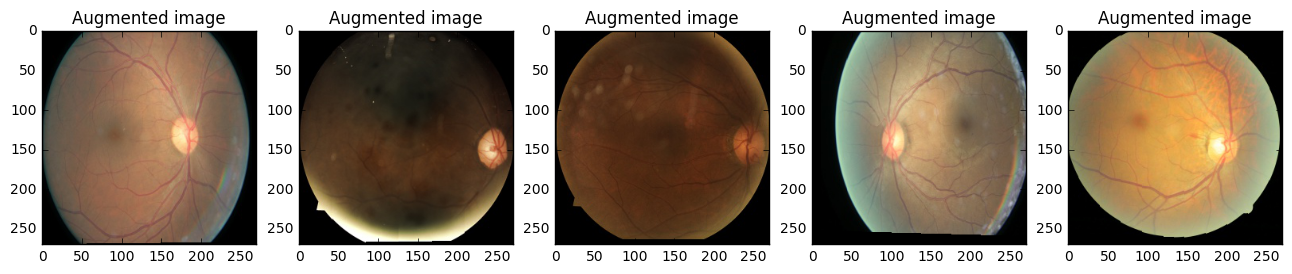

In [79]:
# Plot some examples of augmented images
i=0
for batch in train_gen:
    if i==0:
        fig = plt.figure(figsize=(16, 4))
        for k in range(5):
            plt.subplot(1, 5, k + 1)
            plt.imshow(np.squeeze(batch[0][[k]]))
            plt.title('Augmented image')
        plt.savefig('augmented_images_2.png')
        plt.show()
        i += 1
    else:
        break

#  Training and validating the CNN

In [10]:
##########################################################
# Train, validate and test the network
##########################################################
from keras.optimizers import SGD

# Train with early stopping on the validation dataset\n",
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001,
                               patience=20,
                               verbose=1, mode='auto')

model_checkpoint = ModelCheckpoint('best_model_softmax.hdf5', 
                                   monitor='val_acc', verbose=1, save_best_only=True, 
                                   save_weights_only=False, period=1)

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True),
                           metrics=['accuracy'])

history = model.fit_generator(train_gen, 
                              validation_data=(X_val, y_val.values), 
                              callbacks=[early_stopping, model_checkpoint], 
                              steps_per_epoch=250, epochs=200, verbose=1)

Epoch 1/200
250/250 [==============================] - 224s - loss: 1.6538 - acc: 0.2730 - val_loss: 1.6076 - val_acc: 0.2714
Epoch 2/200
250/250 [==============================] - 215s - loss: 1.5996 - acc: 0.2909 - val_loss: 1.6080 - val_acc: 0.2714
Epoch 3/200
250/250 [==============================] - 216s - loss: 1.5374 - acc: 0.3173 - val_loss: 1.6044 - val_acc: 0.2556
Epoch 4/200
250/250 [==============================] - 215s - loss: 1.4377 - acc: 0.3466 - val_loss: 1.5253 - val_acc: 0.2912
Epoch 5/200
250/250 [==============================] - 217s - loss: 1.3448 - acc: 0.4075 - val_loss: 1.3389 - val_acc: 0.4124
Epoch 6/200
250/250 [==============================] - 215s - loss: 1.3129 - acc: 0.4212 - val_loss: 1.5442 - val_acc: 0.3834
Epoch 7/200
250/250 [==============================] - 213s - loss: 1.2578 - acc: 0.4575 - val_loss: 1.4677 - val_acc: 0.3715
Epoch 8/200
250/250 [==============================] - 212s - loss: 1.2358 - acc: 0.4625 - val_loss: 1.3990 - val_acc:

# Evaluating the model performance

In [9]:
# Compute the QWP score on the validation and test dataset

# Import Kohen Kappa Score
from sklearn.metrics import cohen_kappa_score

# Import best model
from keras.models import load_model
best_model = load_model('best_model_softmax.hdf5')

# Compute predictions traing dataset
train_preds = best_model.predict(X_train)
train_preds = np.argmax(train_preds,axis=1)
train_qwp = cohen_kappa_score(train_preds,np.argmax(y_train.values,axis=1),weights='quadratic')

# Compute predictions validation dataset
val_preds = best_model.predict(X_val)
val_preds = np.argmax(val_preds,axis=1)
val_qwp = cohen_kappa_score(val_preds,np.argmax(y_val.values,axis=1),weights='quadratic')

# Compute predictions test dataset
test_preds = best_model.predict(X_test)
test_preds = np.argmax(test_preds,axis=1)
test_qwp = cohen_kappa_score(test_preds,np.argmax(y_test.values,axis=1),weights='quadratic')

Using TensorFlow backend.


In [11]:
print('Train QWP: ', train_qwp)
print('Validation QWP: ', val_qwp)
print('Test QWP: ', test_qwp)

Train QWP:  0.851390241034
Validation QWP:  0.659923671519
Test QWP:  0.634139437834


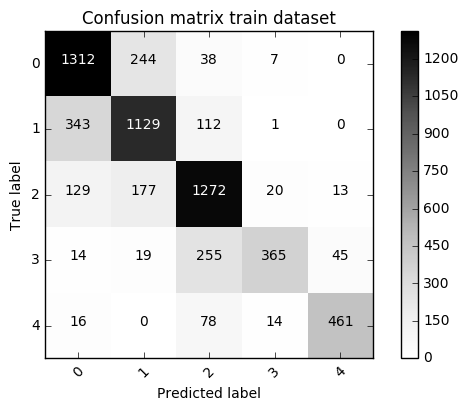

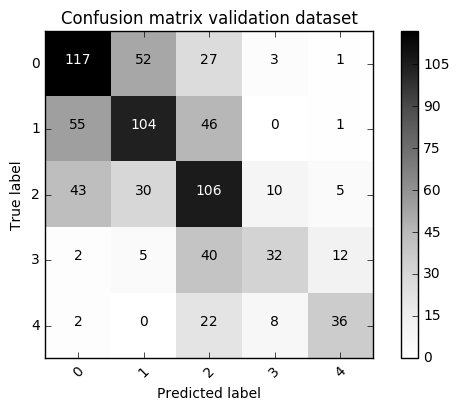

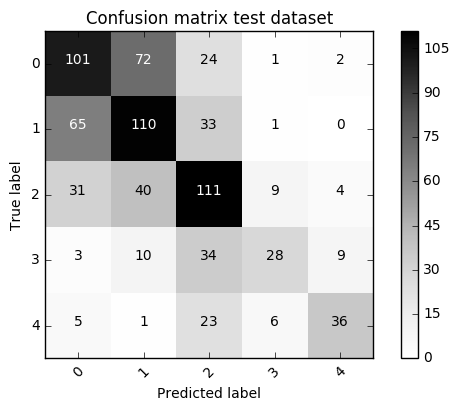

In [12]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
from confusion_plot import plot_confusion_matrix

train_conf = confusion_matrix(np.argmax(y_train.values,axis=1), train_preds)
val_conf = confusion_matrix(np.argmax(y_val.values,axis=1), val_preds)
test_conf = confusion_matrix(np.argmax(y_test.values,axis=1), test_preds)


plot_confusion_matrix(train_conf, classes=[0,1,2,3,4], cmap='Greys',
                      title='Confusion matrix train dataset')
plt.savefig('Train_confusion_matrix.png',bbox_inches='tight')
plt.show()

plot_confusion_matrix(val_conf, classes=[0,1,2,3,4], cmap='Greys',
                      title='Confusion matrix validation dataset')
plt.savefig('Validation_confusion_matrix.png',bbox_inches='tight')
plt.show()

plot_confusion_matrix(test_conf, classes=[0,1,2,3,4], cmap='Greys',
                      title='Confusion matrix test dataset')
plt.savefig('Test_confusion_matrix.png',bbox_inches='tight')
plt.show()

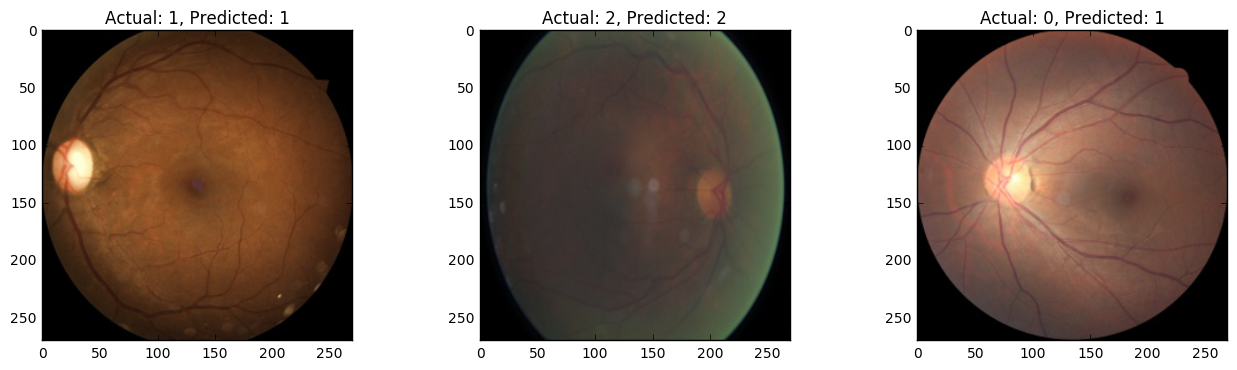

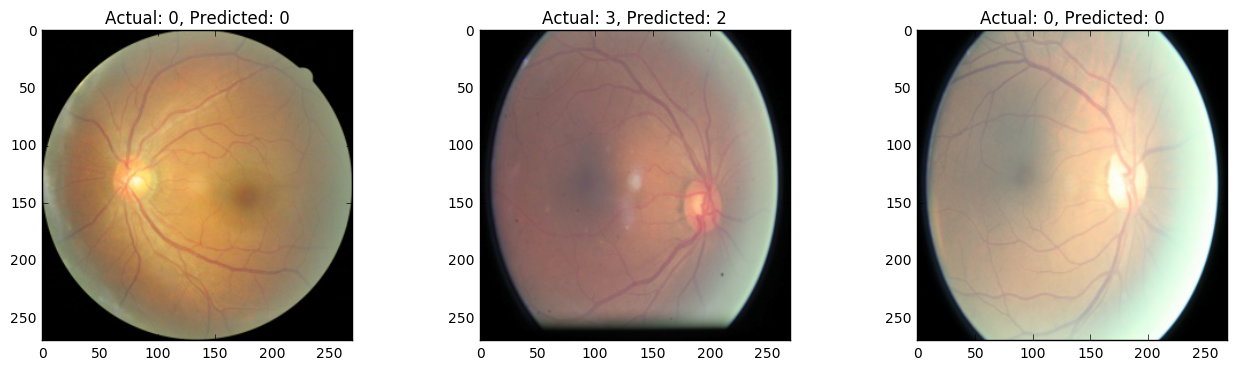

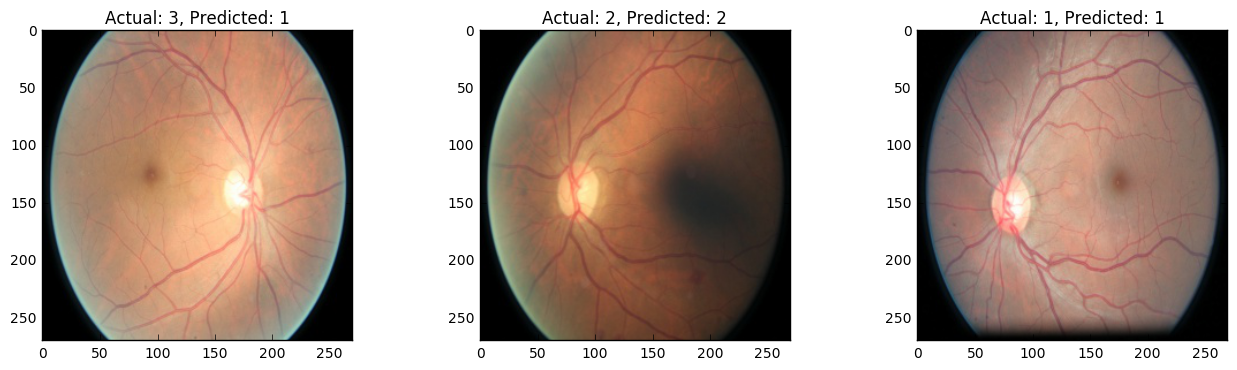

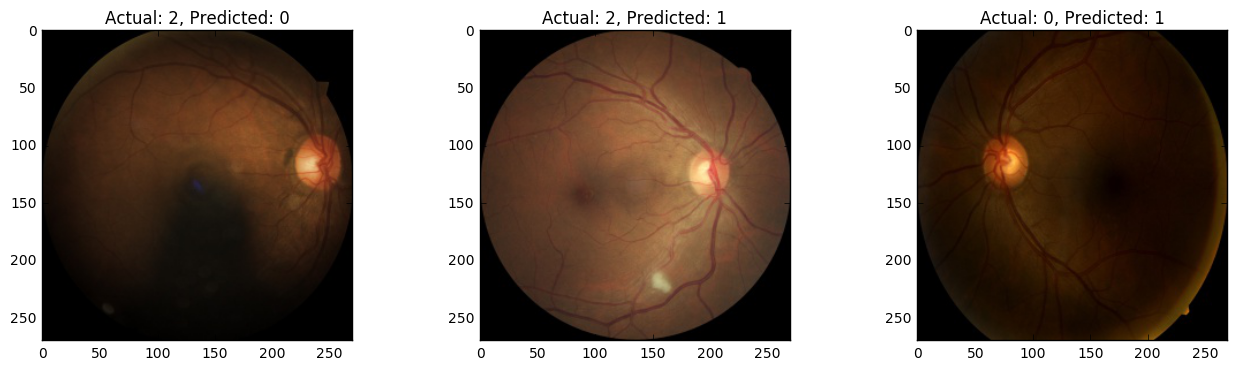

In [16]:
# Plot some examples of images along with the predicted and actual targets
num_display = 3
for levels in range(4):
    fig = plt.figure(figsize=(16, 4))
    for k in range(num_display):
        img = X_val[(k*15+levels*2),:,:,:]
        plt.subplot(1, num_display, k + 1)
        plt.imshow(img)
        plt.title('Actual: %d, Predicted: %d' %(np.argmax(y_val.values,axis=1)[k*15+levels*2], 
                  int(val_preds[k*15+levels*2])))
    plt.savefig('actual_vs_predicted_%d.png' %levels)
    plt.show()
    